<a href="https://colab.research.google.com/github/casjunior93/DIO-Treinamento-de-Redes-Neurais-com-Transfer-Learning/blob/master/Desafio_DIO_Transfer%C3%AAncia_de_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas fundamentais

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import zipfile

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

#from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

# Obtendo o dataset de cães e gatos (upload feito previamente no Google Drive)

In [2]:
%%time
#Autorizando o acesso ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 1.17 s, sys: 210 ms, total: 1.38 s
Wall time: 30.1 s


In [3]:
%%time
local_zip = '/content/drive/MyDrive/ANÁLISES DE DADOS/Dataset cats and dogs/kagglecatsanddogs_5340.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

CPU times: user 7.25 s, sys: 2.94 s, total: 10.2 s
Wall time: 20.9 s


In [4]:
%%time
root = '/tmp/PetImages'
train_split, val_split = 0.7, 0.15

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


In [5]:
%%time
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['/tmp/PetImages/Cat', '/tmp/PetImages/Dog']
CPU times: user 18.1 ms, sys: 9.06 ms, total: 27.2 ms
Wall time: 26.8 ms


Esta função é útil para pré-processar os dados em um vetor de imagem e entrada.

In [6]:
def get_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carrega as imagens da pasta raiz:

In [7]:
%%time
data = []
for c, category in enumerate(categories):
    num_amostra = 0;
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        if num_amostra <= 1500:
          print(img_path, num_amostra)
          img, x = get_image(img_path)
          data.append({'x':np.array(x[0]), 'y':c})
        num_amostra = num_amostra + 1

# conta o numero de classes
num_classes = len(categories)

/tmp/PetImages/Cat/8812.jpg 0
/tmp/PetImages/Cat/5018.jpg 1
/tmp/PetImages/Cat/5071.jpg 2
/tmp/PetImages/Cat/8582.jpg 3
/tmp/PetImages/Cat/7316.jpg 4
/tmp/PetImages/Cat/8198.jpg 5
/tmp/PetImages/Cat/2869.jpg 6
/tmp/PetImages/Cat/8482.jpg 7
/tmp/PetImages/Cat/4743.jpg 8
/tmp/PetImages/Cat/10788.jpg 9
/tmp/PetImages/Cat/844.jpg 10
/tmp/PetImages/Cat/10754.jpg 11
/tmp/PetImages/Cat/8879.jpg 12
/tmp/PetImages/Cat/3713.jpg 13
/tmp/PetImages/Cat/2606.jpg 14
/tmp/PetImages/Cat/2141.jpg 15
/tmp/PetImages/Cat/6820.jpg 16
/tmp/PetImages/Cat/12175.jpg 17
/tmp/PetImages/Cat/11278.jpg 18
/tmp/PetImages/Cat/5318.jpg 19
/tmp/PetImages/Cat/3147.jpg 20
/tmp/PetImages/Cat/5819.jpg 21
/tmp/PetImages/Cat/10325.jpg 22
/tmp/PetImages/Cat/5755.jpg 23
/tmp/PetImages/Cat/12470.jpg 24
/tmp/PetImages/Cat/9811.jpg 25
/tmp/PetImages/Cat/6735.jpg 26
/tmp/PetImages/Cat/375.jpg 27
/tmp/PetImages/Cat/4755.jpg 28
/tmp/PetImages/Cat/8630.jpg 29
/tmp/PetImages/Cat/4141.jpg 30
/tmp/PetImages/Cat/4526.jpg 31
/tmp/PetImages

In [8]:
%%time
random.shuffle(data)

CPU times: user 3.47 ms, sys: 86 µs, total: 3.56 ms
Wall time: 4.99 ms


In [9]:
%%time
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

CPU times: user 39 µs, sys: 8 µs, total: 47 µs
Wall time: 51 µs


In [10]:
%%time
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 

In [11]:
# normalizando os dados, 
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(451, 2)


In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 3002 images from 2 categories
train / validation / test split: 2101, 450, 451
training data shape:  (2101, 224, 224, 3)
training labels shape:  (2101, 2)


CPU times: user 113 ms, sys: 12.7 ms, total: 126 ms
Wall time: 139 ms


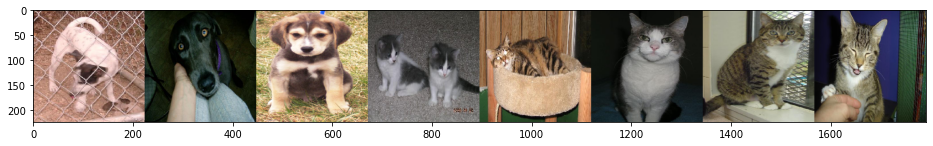

In [13]:
%%time
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Transferência de aprendizado a partir de uma rede existente

Carregar o VGG16 a partir do Keras, que foi treinada usando imagens do ImageNet e que tem os pesos disponíveis para download.

In [14]:
%%time
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [15]:
%%time
# referência à camada de entrada da VGG
inp = vgg.input

# faz uma nova camada softmax com num_classes neurônios 
new_classification_layer = Dense(num_classes, activation='softmax')

# conecta nossa nova camada à penúltima camada em VGG, e faz uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# cria uma nova rede entre inp e out
model_new = Model(inp, out)

# congela todas as camadas para não serem treinadas, exceto a última
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garante que a última camada seja treinada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
%%time
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
17/17 [==============================] - 40s 1s/step - loss: 0.8045 - accuracy: 0.5554 - val_loss: 0.5622 - val_accuracy: 0.6378
Epoch 2/10
17/17 [==============================] - 13s 771ms/step - loss: 0.4705 - accuracy: 0.7925 - val_loss: 0.4772 - val_accuracy: 0.7667
Epoch 3/10
17/17 [==============================] - 13s 793ms/step - loss: 0.3899 - accuracy: 0.8453 - val_loss: 0.3796 - val_accuracy: 0.8511
Epoch 4/10
17/17 [==============================] - 14s 817ms/step - loss: 0.3497 - accuracy: 0.8601 - val_loss: 0.3546 - val_accuracy: 0.8578
Epoch 5/10
17/17 [==============================] - 14s 841ms/step - loss: 0.3186 - accuracy: 0.8758 - val_loss: 0.3341 - val_accuracy: 0.8711
Epoch 6/10
17/17 [==============================] - 14s 833ms/step - loss: 0.2993 - accuracy: 0.8867 - val_loss: 0.3221 - val_accuracy: 0.8733
Epoch 7/10
17/17 [==============================] - 14s 815ms/step - loss: 0.2841 - accuracy: 0.8943 - val_loss: 0.3243 - val_accuracy: 0.8556
Ep

Curvas de perdas e acurácia



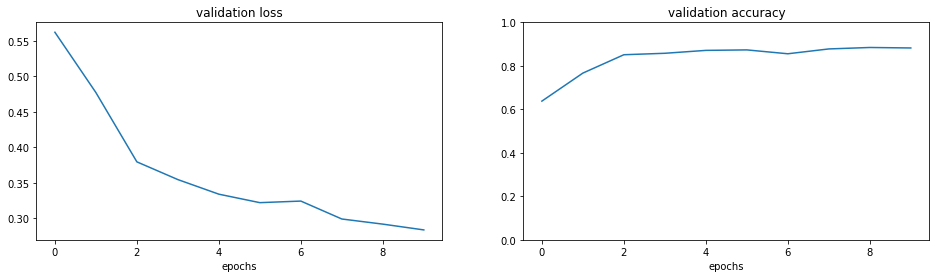

In [17]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Validação final do dataset de teste:

In [18]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.2265874296426773
Test accuracy: 0.9268292784690857


In [19]:
history_dict = history2.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Testando com imagens fora do dataset

Imagem de cão

In [20]:
img, x = get_image('/content/drive/MyDrive/ANÁLISES DE DADOS/Dataset cats and dogs/cao.png')
probabilities = model_new.predict([x])
print(probabilities)

1/1 [==============================] - 1s 844ms/step
[[9.95094e-18 1.00000e+00]]


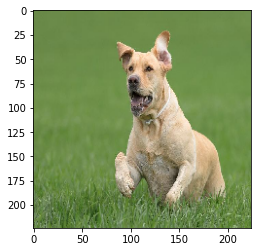

In [21]:
plt.imshow(img)

In [22]:
if probabilities[0][0] > probabilities[0][1]:
    print("Gato")
else:
    print('Cão')

Cão


Imagem de gato

In [23]:
img, x = get_image('/content/drive/MyDrive/ANÁLISES DE DADOS/Dataset cats and dogs/gato.png')
probabilities = model_new.predict([x])
print(probabilities)

1/1 [==============================] - 0s 17ms/step
[[1.0000000e+00 4.3327064e-11]]


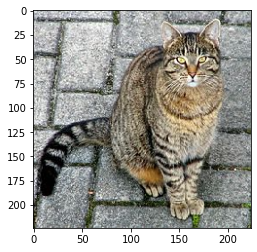

In [24]:
plt.imshow(img)

In [25]:
if probabilities[0][0] > probabilities[0][1]:
    print("Gato")
else:
    print('Cão')

Gato
